# Dissertation Progress Presentation: Demonstration 19 February 2018

This document demonstrates the following:
* Demonstration of the libraries created for my dissertation
* Some spatial optimization implementations
* Some spatial analyses motivating future work

# Contents
* [Imports](#Imports)
* [Data Setup](#Data-Setup)
* [Create AOI and Parameters](#Create-AOI-and-Parameters)
* [Airfield Objective](#Airfield-Objective)
 * [Site Suitability](#Site-Suitability)
 * [Site Configuration](#Site-Configuration)
 * [Site Evaluation](#Site-Evaluation)
* [Camp 1 Objective](#Camp-1-Objective)
* [Camp 2 Objective](#Camp-2-Objective)
* [Site Relations](#Site-Relations)

# Imports

In [140]:
import SpatialIO as io
import FirstPass as firstpass
import pgdissroute as pgdissroute
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
%matplotlib inline
pd.options.display.max_columns = 200

# Data Setup

In [18]:
slopePath = '../FLW_Missouri Mission Folder/RASTER/slope_proj.tif'
elevationPath = "../FLW_Missouri Mission Folder/RASTER/DEM_CMB_ELV_SRTMVF2_proj.tif"
vector_path = './test_data/UtilityInfrastructureCrv_3.shp'
roadsPath = './test_data/tgc.shp'
landcoverPath = '../FLW_Missouri Mission Folder/RASTER/LC_LandCover_GeoCover_proj.tif'

# Create AOI and Parameters

Text(0.5,0.98,u'Areas of Interest')

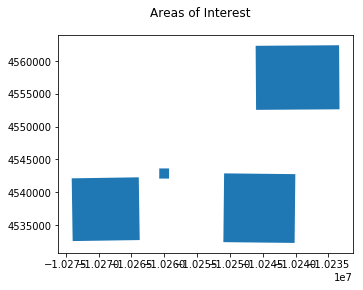

In [54]:
aoiDF = gpd.read_file("../FLW_Missouri Mission Folder/SUPPORT/Staging.shp")
aoiDF = aoiDF.to_crs({'init':'epsg:3857'})
squareDimension = 400
aoiDF.plot()
plt.suptitle("Areas of Interest")

# Airfield Objective

## Site Suitability

In [4]:
airfieldAOI = aoiDF[aoiDF['Stage']=='Gold'].reset_index().geometry[0]
airfieldEvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(airfieldAOI,100)

Generated 12161 squares in 0 seconds


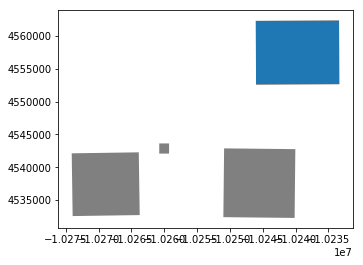

In [63]:
airfieldEvaluationDataFrame.plot(ax=aoiDF.plot(color='grey'))

In [6]:
airfieldSlopeEvaluationDataFrame = firstpass.generateRasterStatisticsForDataFrame(airfieldEvaluationDataFrame,slopePath,stats="mean max",isCategorical=False)


/home/noah/anaconda2/lib/python2.7/site-packages/rasterstats/main.py:142: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/home/noah/anaconda2/lib/python2.7/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)


Text(0.5,0.98,u'Zonal Calculation of Maximum Slope over AOI')

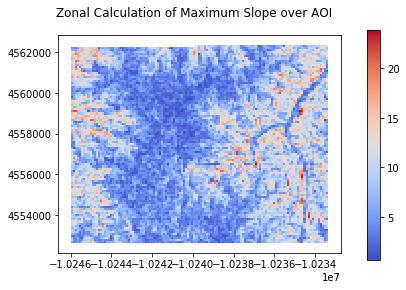

In [52]:
vmin = min(airfieldSlopeEvaluationDataFrame['max'])
vmax = max(airfieldSlopeEvaluationDataFrame['max'])
ax = airfieldSlopeEvaluationDataFrame.plot(column='max', cmap='coolwarm', vmin=vmin, vmax=vmax)
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.suptitle("Zonal Calculation of Maximum Slope over AOI")

Text(0,0.5,u'Fraction of AOI Evaluation Grid')

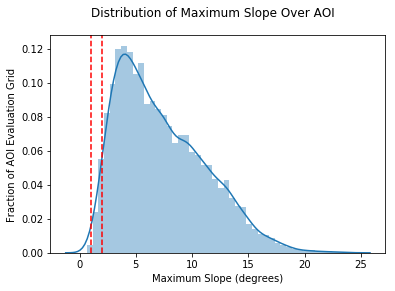

In [44]:
sns.distplot(airfieldSlopeEvaluationDataFrame['max'])
plt.axvline(1, color='red', linestyle='--')
plt.axvline(2, color='red', linestyle='--')
plt.suptitle("Distribution of Maximum Slope Over AOI")
plt.xlabel("Maximum Slope (degrees)")
plt.ylabel("Fraction of AOI Evaluation Grid")

**Subset by maximum slope < 2**

In [9]:
airfieldSlopeEvaluationDataFrameSubset = airfieldSlopeEvaluationDataFrame[airfieldSlopeEvaluationDataFrame['max'] < 2]
print "Subset consists of %s areas, reduced from the original %s areas" %(len(airfieldSlopeEvaluationDataFrameSubset.index),len(airfieldSlopeEvaluationDataFrame.index))

Subset consists of 364 areas, reduced from the original 12161 areas


Text(0.5,0.98,u'New Evaluation Areas')

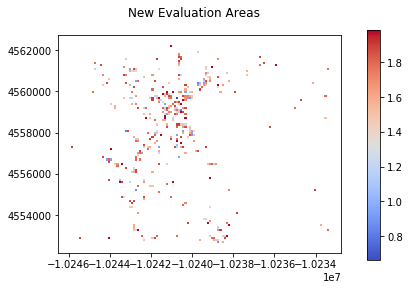

In [53]:
vmin = min(airfieldSlopeEvaluationDataFrameSubset['max'])
vmax = max(airfieldSlopeEvaluationDataFrameSubset['max'])
ax = airfieldSlopeEvaluationDataFrameSubset.plot(column='max', cmap='coolwarm', vmin=vmin, vmax=vmax)
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.suptitle("New Evaluation Areas")

**Create Larger Candidate Sites Using the Simplified Approach**

**Distance to Linear Features**

In [36]:
roadsDF = gpd.read_file(roadsPath)
roadsDF.crs = {'init':'epsg:3857'}
roadsDF = roadsDF.to_crs({'init':'epsg:3857'})

In [37]:
lx,ly,ux,uy = airfieldEvaluationDataFrame.total_bounds
bufferDistance = 1000
lx -= bufferDistance
ly += bufferDistance
ux -= bufferDistance
uy += bufferDistance
roadsDF = firstpass.filterDataFrameByBounds(roadsDF,lx,ly,ux,uy)

Text(0.5,0.98,u'Roads Near the AOI')

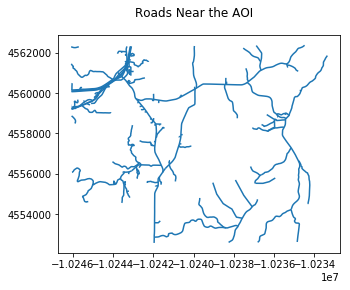

In [39]:
roadsDF.plot()
plt.suptitle("Roads Near the AOI")

In [40]:
airfieldEvaluationDataFrame = firstpass.minimumDistanceFromEvaluationToDataFrameFeatures(airfieldEvaluationDataFrame,roadsDF)

Text(0.5,0.98,u'Distance of each site from nearest MSR')

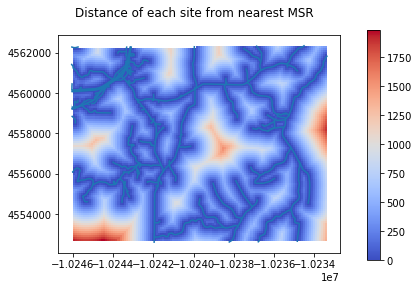

In [41]:
vmin = min(airfieldEvaluationDataFrame['distance'])
vmax = max(airfieldEvaluationDataFrame['distance'])
ax = airfieldEvaluationDataFrame.plot(column='distance', cmap='coolwarm', vmin=vmin, vmax=vmax, ax=roadsDF.plot())
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
fig.suptitle("Distance of each site from nearest MSR")

Text(0,0.5,u'Fraction of Candidate Sites')

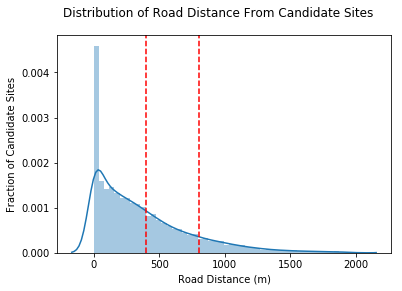

In [42]:
sns.distplot(airfieldEvaluationDataFrame['distance'])
plt.axvline(400, color='red', linestyle='--')
plt.axvline(800, color='red', linestyle='--')
plt.suptitle("Distribution of Road Distance From Candidate Sites")
plt.xlabel("Road Distance (m)")
plt.ylabel("Fraction of Candidate Sites")

## Site Configuration

In [11]:
largerPolygonDimension = 800
largerAirfields = firstpass.convertSubsettedEvaluationDFIntoPolygonGrid(airfieldSlopeEvaluationDataFrameSubset, largerPolygonDimension)

Text(0.5,0.98,u'Site Configuration for Airfield')

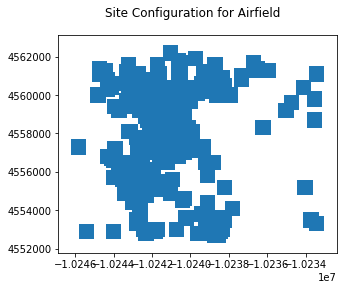

In [12]:
largerAirfields.plot()
plt.suptitle("Site Configuration for Airfield")

## Site Evaluation

**Calculate Cut Fill For Objective Function**

In [13]:
cutFillDF = firstpass.calculateCutFill(largerAirfields,elevationPath,finalElevation='mean',rasterResolution=1)

Text(0.5,0.98,u'Cut Fill Required for Candidate Airfields (m^3)')

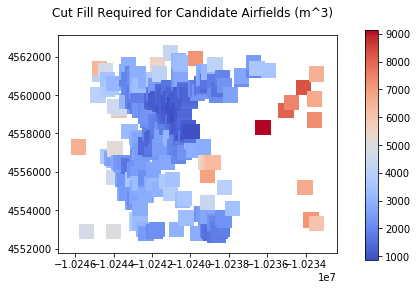

In [45]:
vmin = min(cutFillDF['totalCutFillVolume'])
vmax = max(cutFillDF['totalCutFillVolume'])
ax = cutFillDF.plot(column='totalCutFillVolume', cmap='coolwarm', vmin=vmin, vmax=vmax)

# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
fig.suptitle("Cut Fill Required for Candidate Airfields (m^3)")

Text(0,0.5,u'Fraction of Candidate Sites')

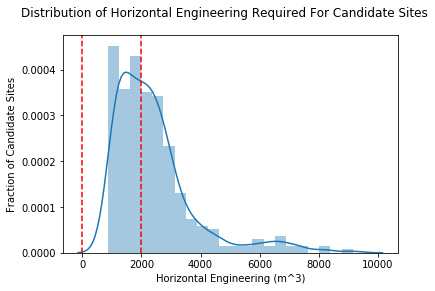

In [46]:
sns.distplot(cutFillDF['totalCutFillVolume'])
plt.axvline(0, color='red', linestyle='--')
plt.axvline(2000, color='red', linestyle='--')
plt.suptitle("Distribution of Horizontal Engineering Required For Candidate Sites")
plt.xlabel("Horizontal Engineering (m^3)")
plt.ylabel("Fraction of Candidate Sites")

# Camp 1 Objective

In [60]:
baseObjective1AOI = aoiDF[aoiDF['Stage']=='Red'].reset_index().geometry[0]
baseObjective1EvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(baseObjective1AOI,100)

Generated 9551 squares in 0 seconds


Text(0.5,0.98,u'Context: Location of Site 1')

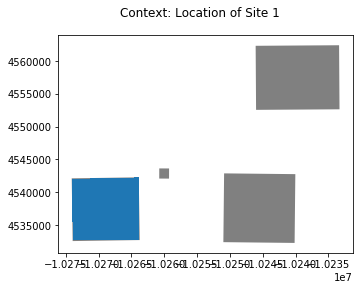

In [75]:
baseObjective1EvaluationDataFrame.plot(ax=aoiDF.plot(color='grey'))
plt.suptitle("Context: Location of Site 1")

In [67]:
site1SlopeEvaluationDataFrame = firstpass.generateRasterStatisticsForDataFrame(baseObjective1EvaluationDataFrame,slopePath,stats="mean max",isCategorical=False)

Text(0.5,0.98,u'Zonal Calculation of Maximum Slope over AOI')

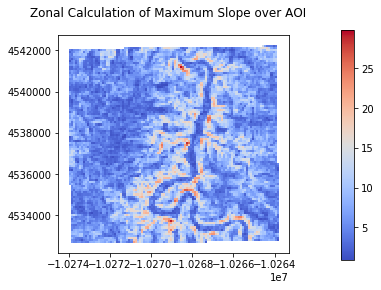

In [68]:
vmin = min(site1SlopeEvaluationDataFrame['max'])
vmax = max(site1SlopeEvaluationDataFrame['max'])
ax = site1SlopeEvaluationDataFrame.plot(column='max', cmap='coolwarm', vmin=vmin, vmax=vmax)
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.suptitle("Zonal Calculation of Maximum Slope over AOI")

In [73]:
roadsDF = gpd.read_file(roadsPath)
roadsDF.crs = {'init':'epsg:3857'}
roadsDF = roadsDF.to_crs({'init':'epsg:3857'})

lx,ly,ux,uy = site1SlopeEvaluationDataFrame.total_bounds
bufferDistance = 1000
lx -= bufferDistance
ly += bufferDistance
ux -= bufferDistance
uy += bufferDistance
roadsDF = firstpass.filterDataFrameByBounds(roadsDF,lx,ly,ux,uy)

site1SlopeEvaluationDataFrame = firstpass.minimumDistanceFromEvaluationToDataFrameFeatures(site1SlopeEvaluationDataFrame,roadsDF)

Text(0.5,0.98,u'Distance of each site from nearest MSR')

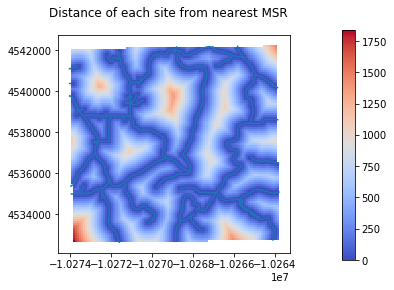

In [74]:
vmin = min(site1SlopeEvaluationDataFrame['distance'])
vmax = max(site1SlopeEvaluationDataFrame['distance'])
ax = site1SlopeEvaluationDataFrame.plot(column='distance', cmap='coolwarm', vmin=vmin, vmax=vmax, ax=roadsDF.plot())
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
fig.suptitle("Distance of each site from nearest MSR")

# Camp 2 Objective

In [64]:
baseObjective2AOI = aoiDF[aoiDF['Stage']=='Blue'].reset_index().geometry[0]
baseObjective2EvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(baseObjective2AOI,100)

Generated 11141 squares in 0 seconds


Text(0.5,0.98,u'Context: Location of Site 2')

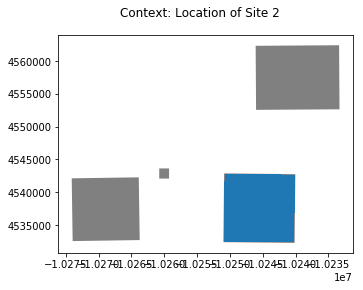

In [76]:
baseObjective2EvaluationDataFrame.plot(ax=aoiDF.plot(color='grey'))
plt.suptitle("Context: Location of Site 2")

In [78]:
site2SlopeEvaluationDataFrame = firstpass.generateRasterStatisticsForDataFrame(baseObjective2EvaluationDataFrame,slopePath,stats="mean max",isCategorical=False)

Text(0.5,0.98,u'Zonal Calculation of Maximum Slope over AOI')

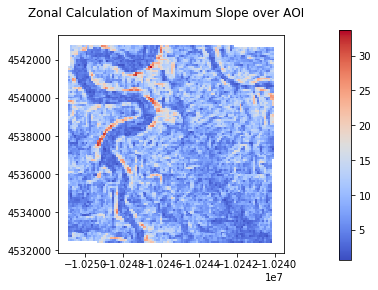

In [79]:
vmin = min(site2SlopeEvaluationDataFrame['max'])
vmax = max(site2SlopeEvaluationDataFrame['max'])
ax = site2SlopeEvaluationDataFrame.plot(column='max', cmap='coolwarm', vmin=vmin, vmax=vmax)
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.suptitle("Zonal Calculation of Maximum Slope over AOI")

In [82]:
roadsDF = gpd.read_file(roadsPath)
roadsDF.crs = {'init':'epsg:3857'}
roadsDF = roadsDF.to_crs({'init':'epsg:3857'})

lx,ly,ux,uy = site2SlopeEvaluationDataFrame.total_bounds
bufferDistance = 1000
lx -= bufferDistance
ly += bufferDistance
ux -= bufferDistance
uy += bufferDistance
roadsDF = firstpass.filterDataFrameByBounds(roadsDF,lx,ly,ux,uy)

site2SlopeEvaluationDataFrame = firstpass.minimumDistanceFromEvaluationToDataFrameFeatures(site2SlopeEvaluationDataFrame,roadsDF)

# Site Relations

**Set Up Three Candidate Solution DataFrames**

In [58]:
airfieldCandidates = cutFillDF[cutFillDF['totalCutFillVolume'] < 2000]
print "Evaluating %s candidates for the airfield site" %(len(airfieldCandidates.index))

Evaluating 170 candidats for the airfield site


In [134]:
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['distance'] > 400]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['distance'] < 800]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['mean'] > 2]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['mean'] < 5]
randomIndexes = np.random.randint(0,len(site1Candidates.index),100)
site1Candidates = site1Candidates.iloc[randomIndexes,:]
print "Evaluating %s candidates for the Site 1" %(len(site1Candidates.index))

Evaluating 100 candidates for the Site 1


In [135]:
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['distance'] > 400]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['distance'] < 800]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['mean'] > 2]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['mean'] < 5]
randomIndexes = np.random.randint(0,len(site2Candidates.index),100)
site2Candidates = site2Candidates.iloc[randomIndexes,:]
print "Evaluating %s candidates for the Site 1" %(len(site2Candidates.index))

Evaluating 100 candidates for the Site 1


Text(0.5,0.98,u'Candidate Sites for Relational Analysis')

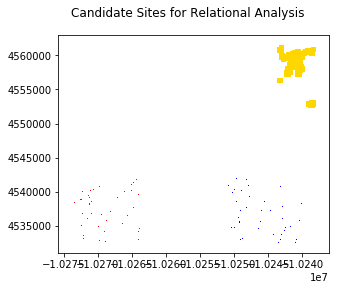

In [136]:
airfieldCandidates.plot(color='gold',ax=site1Candidates.plot(color='red',ax=site2Candidates.plot(color='blue')))
plt.suptitle("Candidate Sites for Relational Analysis")

In [81]:
m = io.Map()
m.test_addTimeSeriesHeatMap()
m.map

# Notes for Future Work

**Epistasis by Index**

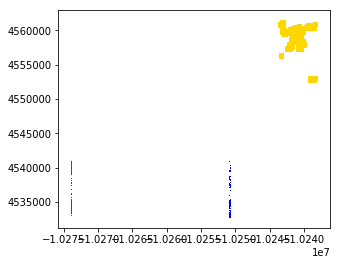

In [116]:
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['distance'] > 400]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['distance'] < 800]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['mean'] > 2]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['mean'] < 5]
site1Candidates = site1Candidates[0:100]

site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['distance'] > 400]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['distance'] < 800]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['mean'] > 2]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['mean'] < 5]
site2Candidates = site2Candidates[0:100]

airfieldCandidates.plot(color='gold',ax=site1Candidates.plot(color='red',ax=site2Candidates.plot(color='blue')))

Text(0.5,0.98,u'Demonstration of Epistasis: Candidate Sites by Index')

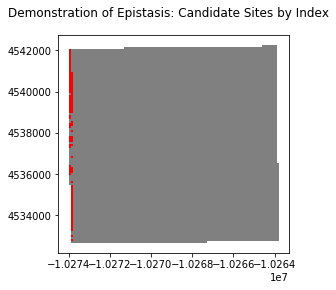

In [123]:
site1Candidates.plot(color='red',ax=site1SlopeEvaluationDataFrame.plot(color='grey'))
plt.suptitle("Demonstration of Epistasis: Candidate Sites by Index")